In [1]:
"""
File Created: 2023-12-06
Author: Patrick G. Cho
Contact: pcho@nd.edu
Purpose: Significant Correlation Analysis of d18O_P on different timescales

Details:
This script is designed to illustrate the spatio-temporal relationship between the IWC and PWC metrics and the d18O_P fields in ECHAM5-wiso. The analysis encompasses various timescales the east African Short Rains (October, November, December), as well as Annual, Three-Year, and Five-Year intervals. Additionally, we employ multiple regression to analyze the extent to which the Walker Circulation influences water isotopes on different timescales. The script achieves this by downsampling the time series data into the specified intervals. The study period spans from 1958 to 2013.

In summary, this notebook will produce the foundational figures for Figure 2 and Figure S2. It also has the multivariate analysis that is shown in Table S1. 
"""

'\nFile Created: 2023-12-06\nAuthor: Patrick G. Cho\nContact: pcho@nd.edu\nPurpose: Significant Correlation Analysis of d18O_P on different timescales\n\nDetails:\nThis script is designed to illustrate the spatio-temporal relationship between the IWC and PWC metrics and the d18O_P fields in ECHAM5-wiso. The analysis encompasses various timescales the east African Short Rains (October, November, December), as well as Annual, Three-Year, and Five-Year intervals. Additionally, we employ multiple regression to analyze the extent to which the Walker Circulation influences water isotopes on different timescales. The script achieves this by downsampling the time series data into the specified intervals. The study period spans from 1958 to 2013.\n'

# Load Packages

In [1]:
# Data Management
import pandas as pd
import xarray as xr
import dask.array as dask
import cftime

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Correlation Analysis
import numpy as np
import numpy.ma as ma
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm

# Calculations
from amount_weighted_ann_mean import amount_weighted_ann_mean
from weighted_temporal_mean import weighted_temporal_mean

# Image Resolution on MacOS
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Clean Data

In [4]:
path = 'YOUR_FILE_PATH' # please put in your file path where you are going to store the data.

# IWC Metrics: Zonal Winds, SLP Gradient, DMI, SOI; 1979-2019
metrics            = pd.read_csv(path+'230418_PC_IWCMetrics.csv')
metrics['time']    = pd.to_datetime(metrics['time'])
metrics            = metrics.set_index('time')['1957-12-16' : '2013-12-16'] 
 
metricsMon         = metrics[['u10','DMI','dSLP','dSLPP','SOI']].copy() # Copy of Monthly Metrics
metricsMon['Year'] = metricsMon.index.year.values

metrics  = metrics[['u10','DMI','dSLP','dSLPP']]
metrics  = metrics.resample('Y').mean() # Resample to Annual Resolution
metrics['Year'] = metrics.index.year.values

# Winds; U is the Eastward Component at 10 meters
era = xr.open_dataset(path+ERA5Wind2.nc').coarsen(longitude=10).mean().coarsen(latitude=7).mean()
era = era.assign_coords(longitude=(((era.longitude+180)%360)-180)).sortby(variables = 'longitude',ascending = True)
era = era.sortby(variables = 'latitude', ascending = True).rename({'latitude':'Latitude','longitude':'Longitude'})
era = era.sel(Latitude=slice(-40,30),Longitude=slice(25,120),time=slice('1957','2013'))

# Sea Level Pressure
hadslp = xr.open_dataset(path+'hadslp2r.mnmean.real.nc')
hadslp = hadslp.assign_coords(lon=(((hadslp.lon+180)%360)-180))
hadslp = hadslp.sortby(variables=['lon','lat'],ascending=True).rename({'lat':'Latitude','lon':'Longitude'})
hadslp = hadslp.sel(Latitude=slice(-40,30),Longitude=slice(25,120),time=slice('1957','2013'))

# ECHAM; 1958-2013
a = xr.open_dataset(path+'Echam5-wiso.PD_nudged.d18O_prec.nc')
a = a.rename({'lat':'Latitude','lon':'Longitude'})
a = a.assign_coords(Longitude = ((a.Longitude+180)%360)-180).sortby(variables = ['Longitude','Latitude'], ascending = True)
a = a.mean(dim='lev')

b = xr.open_dataset(path+'Echam5-wiso.PD_nudged.prec.nc')
b = b.rename({'lat':'Latitude','lon':'Longitude'})
b = b.assign_coords(Longitude = ((b.Longitude+180)%360)-180).sortby(variables = ['Longitude','Latitude'], ascending = True)

echam = a.merge(b)
echam = echam.rename({'wisoaprt_d':'d18O_P','aprt':'precip'})

IOB   = echam.sel(Latitude=slice(-40,30),Longitude=slice(25,120)) # Set Bounding box for IOB

# Compute Amount-Weighted Annual Means
isotopes = amount_weighted_ann_mean(IOB,'precip',['d18O_P'])
isotopes['precip'] = weighted_temporal_mean(IOB,'precip')
isotopes = isotopes - isotopes.mean(dim='time')

# OND
OND = IOB[['d18O_P']].sel(time=(IOB.time.dt.month >= 10) & (IOB.time.dt.month <= 12)).resample(time='Y').mean()
OND = OND.groupby('time.month') - OND.groupby('time.month').mean(dim='time')

# Calculate different temporal aggregations
roll3 = isotopes.resample(time = '3Y').mean()
roll10 = isotopes.resample(time = '10Y').mean()
roll3o = OND.resample(time = '3Y').mean()
roll10o = OND.resample(time = '10Y').mean()
metrics3 = metrics.resample('3Y').mean()
metrics10 = metrics.resample('10Y').mean()

# Spatial Analysis

## Computes Spatial  Correlations

In [4]:
def compute_correlations(data, metrics, index):
    """
    This function calculates the 
    """
    cor_map = IOB.precip.isel(time=0) * 0
    cor_map_p = IOB.precip.isel(time=0) * 0

    for j in np.arange(len(data.Latitude)):
        for i in np.arange(len(data.Longitude)):
            valid_indices = np.isfinite(data.d18O_P.values[:, j, i])

            if np.sum(valid_indices) >= 2:
                correlation, p_value = pearsonr(data.d18O_P.values[:, j, i][valid_indices],metrics[index].values[valid_indices])
                if p_value < 0.05:
                    cor_map.values[j, i] = correlation
                    cor_map_p.values[j, i] = p_value

    return cor_map, cor_map_p

In [5]:
# OND Correlation Maps
cor_mapOWSR, cor_mapOWpSR = compute_correlations(OND, metrics, 'u10')
cor_mapOSLPSR, cor_mapOSLPpSR = compute_correlations(OND, metrics, 'dSLP')
cor_mapPWCSR, cor_mapPWCpSR = compute_correlations(OND, metrics, 'dSLPP')

# Amount-Weighted Annual Means
cor_mapOW, cor_mapOWp = compute_correlations(isotopes, metrics, 'u10')
cor_mapOSLP, cor_mapOSLPp = compute_correlations(isotopes, metrics, 'dSLP')
cor_mapPWC, cor_mapPWCp = compute_correlations(isotopes, metrics, 'dSLPP')

# 3 and 10 Year Averages from Precipitation Amount-Weighted Annual Means; This is a work around for individual coherence from frequency.
cor_mapOW3, cor_mapOWp3 = compute_correlations(roll3, metrics3, 'u10')
cor_mapOSLP3, cor_mapOSLPp3 = compute_correlations(roll3, metrics3, 'dSLP')
cor_mapPWC3, cor_mapPWCp3 = compute_correlations(roll3, metrics3, 'dSLPP')

cor_mapOW10, cor_mapOWp10 = compute_correlations(roll10, metrics10, 'u10')
cor_mapOSLP10, cor_mapOSLPp10 = compute_correlations(roll10, metrics10, 'dSLP')
cor_mapPWC10, cor_mapPWCp10 = compute_correlations(roll10, metrics10, 'dSLPP')

# Rolling Windows for OND; Computes Correlation Coefficient for different Rolling Means; A work around frequencies
cor_mapOW3o, cor_mapOWp3o = compute_correlations(roll3o, metrics3, 'u10')
cor_mapOSLP3o, cor_mapOSLPp3o = compute_correlations(roll3o, metrics3, 'dSLP')
cor_mapPWC3o, cor_mapPWCp3o = compute_correlations(roll3o, metrics3, 'dSLPP')

cor_mapOW10o, cor_mapOWp10o = compute_correlations(roll10o, metrics10, 'u10')
cor_mapOSLP10o, cor_mapOSLPp10o = compute_correlations(roll10o, metrics10, 'dSLP')
cor_mapPWC10o, cor_mapPWCp10o = compute_correlations(roll10o, metrics10, 'dSLPP')

/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


# Figure 2

/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'extedn'
  result = super().contourf(*args, **kwargs)
/var/folders/2k/2vgl0pwd6gnfr1h_2nrk8p8c0000gn/T/ipykernel_4491/891472460.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


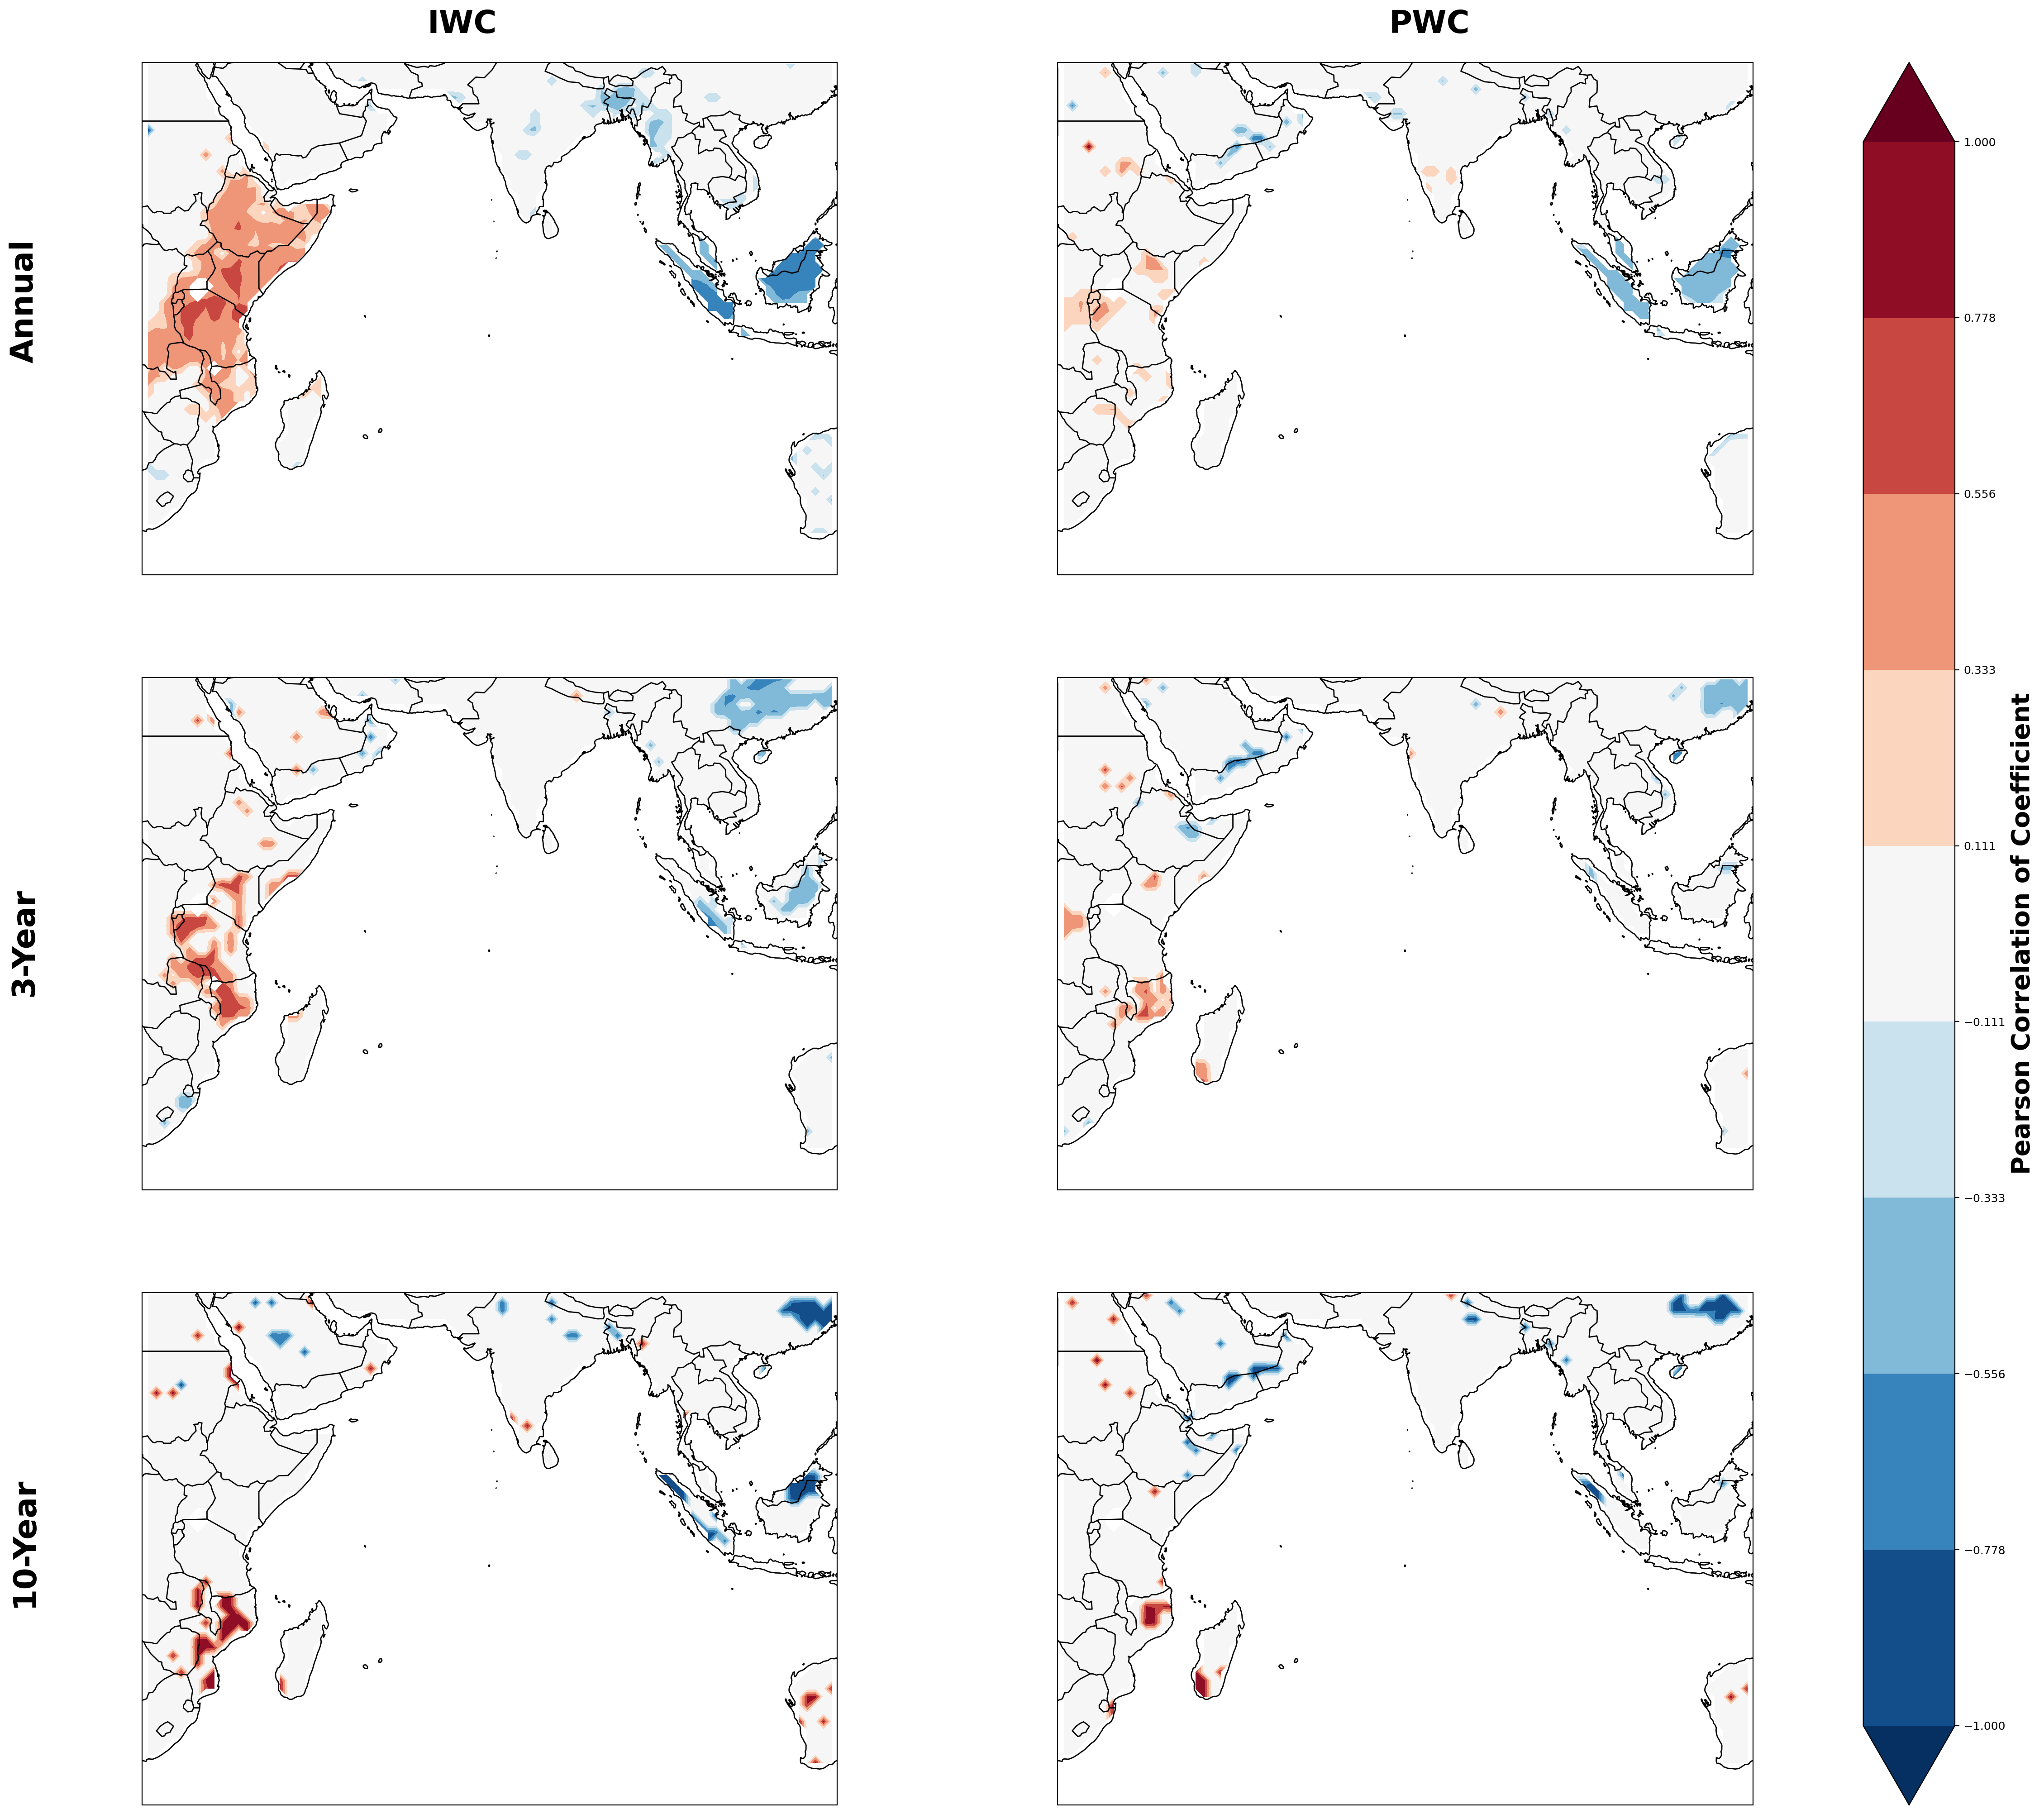

In [30]:
# Spatial Correlation with Colored Contours and IWC and PWC for each Column; Both Columns are OND
fig = plt.figure(figsize=(25,25))
gs = gridspec.GridSpec(nrows=3, ncols=3, height_ratios=[1,1,1], width_ratios=[1,1,0.1], figure=fig)
gs.update(left=0.1, right=0.95, wspace = 0, hspace=0.2)

levels = np.linspace(-1, 1, 10)

# IWC; OND Annual
ax1 = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=0))
cont1 = ax1.contourf(cor_mapOWSR.Longitude, cor_mapOWSR.Latitude, cor_mapOWSR.values, levels=levels, extend='both', cmap='RdBu_r')
ax1.set_extent(extent, ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.BORDERS)

# PWC; OND Annual 
ax2 = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=0))
cont2 = ax2.contourf(cor_mapPWCSR.Longitude, cor_mapPWCSR.Latitude, cor_mapPWCSR.values, levels=levels, extedn='both', cmap='RdBu_r')
ax2.set_extent(extent, ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeature.BORDERS)

# IWC; OND 3-Year
ax3 = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree(central_longitude=0))
cont3 = ax3.contourf(cor_mapOW3o.Longitude, cor_mapOW3o.Latitude, cor_mapOW3o.values, levels=levels, extend='both', cmap='RdBu_r')
ax3.set_extent(extent, ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax3.add_feature(cfeature.BORDERS)

# PWC; OND 3-Year
ax4 = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree(central_longitude=0))
cont4 = ax4.contourf(cor_mapPWC3o.Longitude, cor_mapPWC3o.Latitude, cor_mapPWC3o.values, levels=levels, extend='both',cmap='RdBu_r')
ax4.set_extent(extent, ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax4.add_feature(cfeature.BORDERS)

# IWC; OND 10-Year
ax5 = fig.add_subplot(gs[2,0],projection=ccrs.PlateCarree(central_longitude=0))
cont5 = ax5.contourf(cor_mapOW10o.Longitude, cor_mapOW10o.Latitude, cor_mapOW10o.values, levels=levels, extend='both', cmap='RdBu_r')
ax5.set_extent(extent, ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax5.add_feature(cfeature.BORDERS)

# PWC; OND 10-Year
ax6 = fig.add_subplot(gs[2,1],projection=ccrs.PlateCarree(central_longitude=0))
cont6 = ax6.contourf(cor_mapPWC10o.Longitude, cor_mapPWC10o.Latitude, cor_mapPWC10o.values, levels=levels, extend='both', cmap='RdBu_r')
ax6.set_extent(extent, ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax6.add_feature(cfeature.BORDERS)

fig.text(0.275, 0.893, 'IWC', fontsize = 25, fontweight = 'bold', color = 'k')
fig.text(0.7, 0.893, 'PWC', fontsize = 25, fontweight = 'bold', color = 'k')
fig.text(0.09, 0.75, 'Annual', fontsize = 25, fontweight = 'bold',rotation = 90, color = 'k')
fig.text(0.09, 0.47, '3-Year', fontsize = 25, fontweight = 'bold',rotation = 90, color = 'k')
fig.text(0.09, 0.2, '10-Year', fontsize = 25, fontweight = 'bold',rotation = 90, color = 'k')

ax7 = fig.add_subplot(gs[:,2])
cbar = plt.colorbar(cont1, cax=ax7, orientation='vertical') 
cbar.ax.tick_params(labelsize=9)
cbar.set_label('Pearson Correlation of Coefficient', fontsize=20, fontweight='bold')

plt.tight_layout()
#plt.savefig(path+'FILE_NAME.eps',bbox_inches='tight',dpi=600)


# Figure S2

/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'extedn'
  result = super().contourf(*args, **kwargs)
/var/folders/2k/2vgl0pwd6gnfr1h_2nrk8p8c0000gn/T/ipykernel_4491/978712116.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


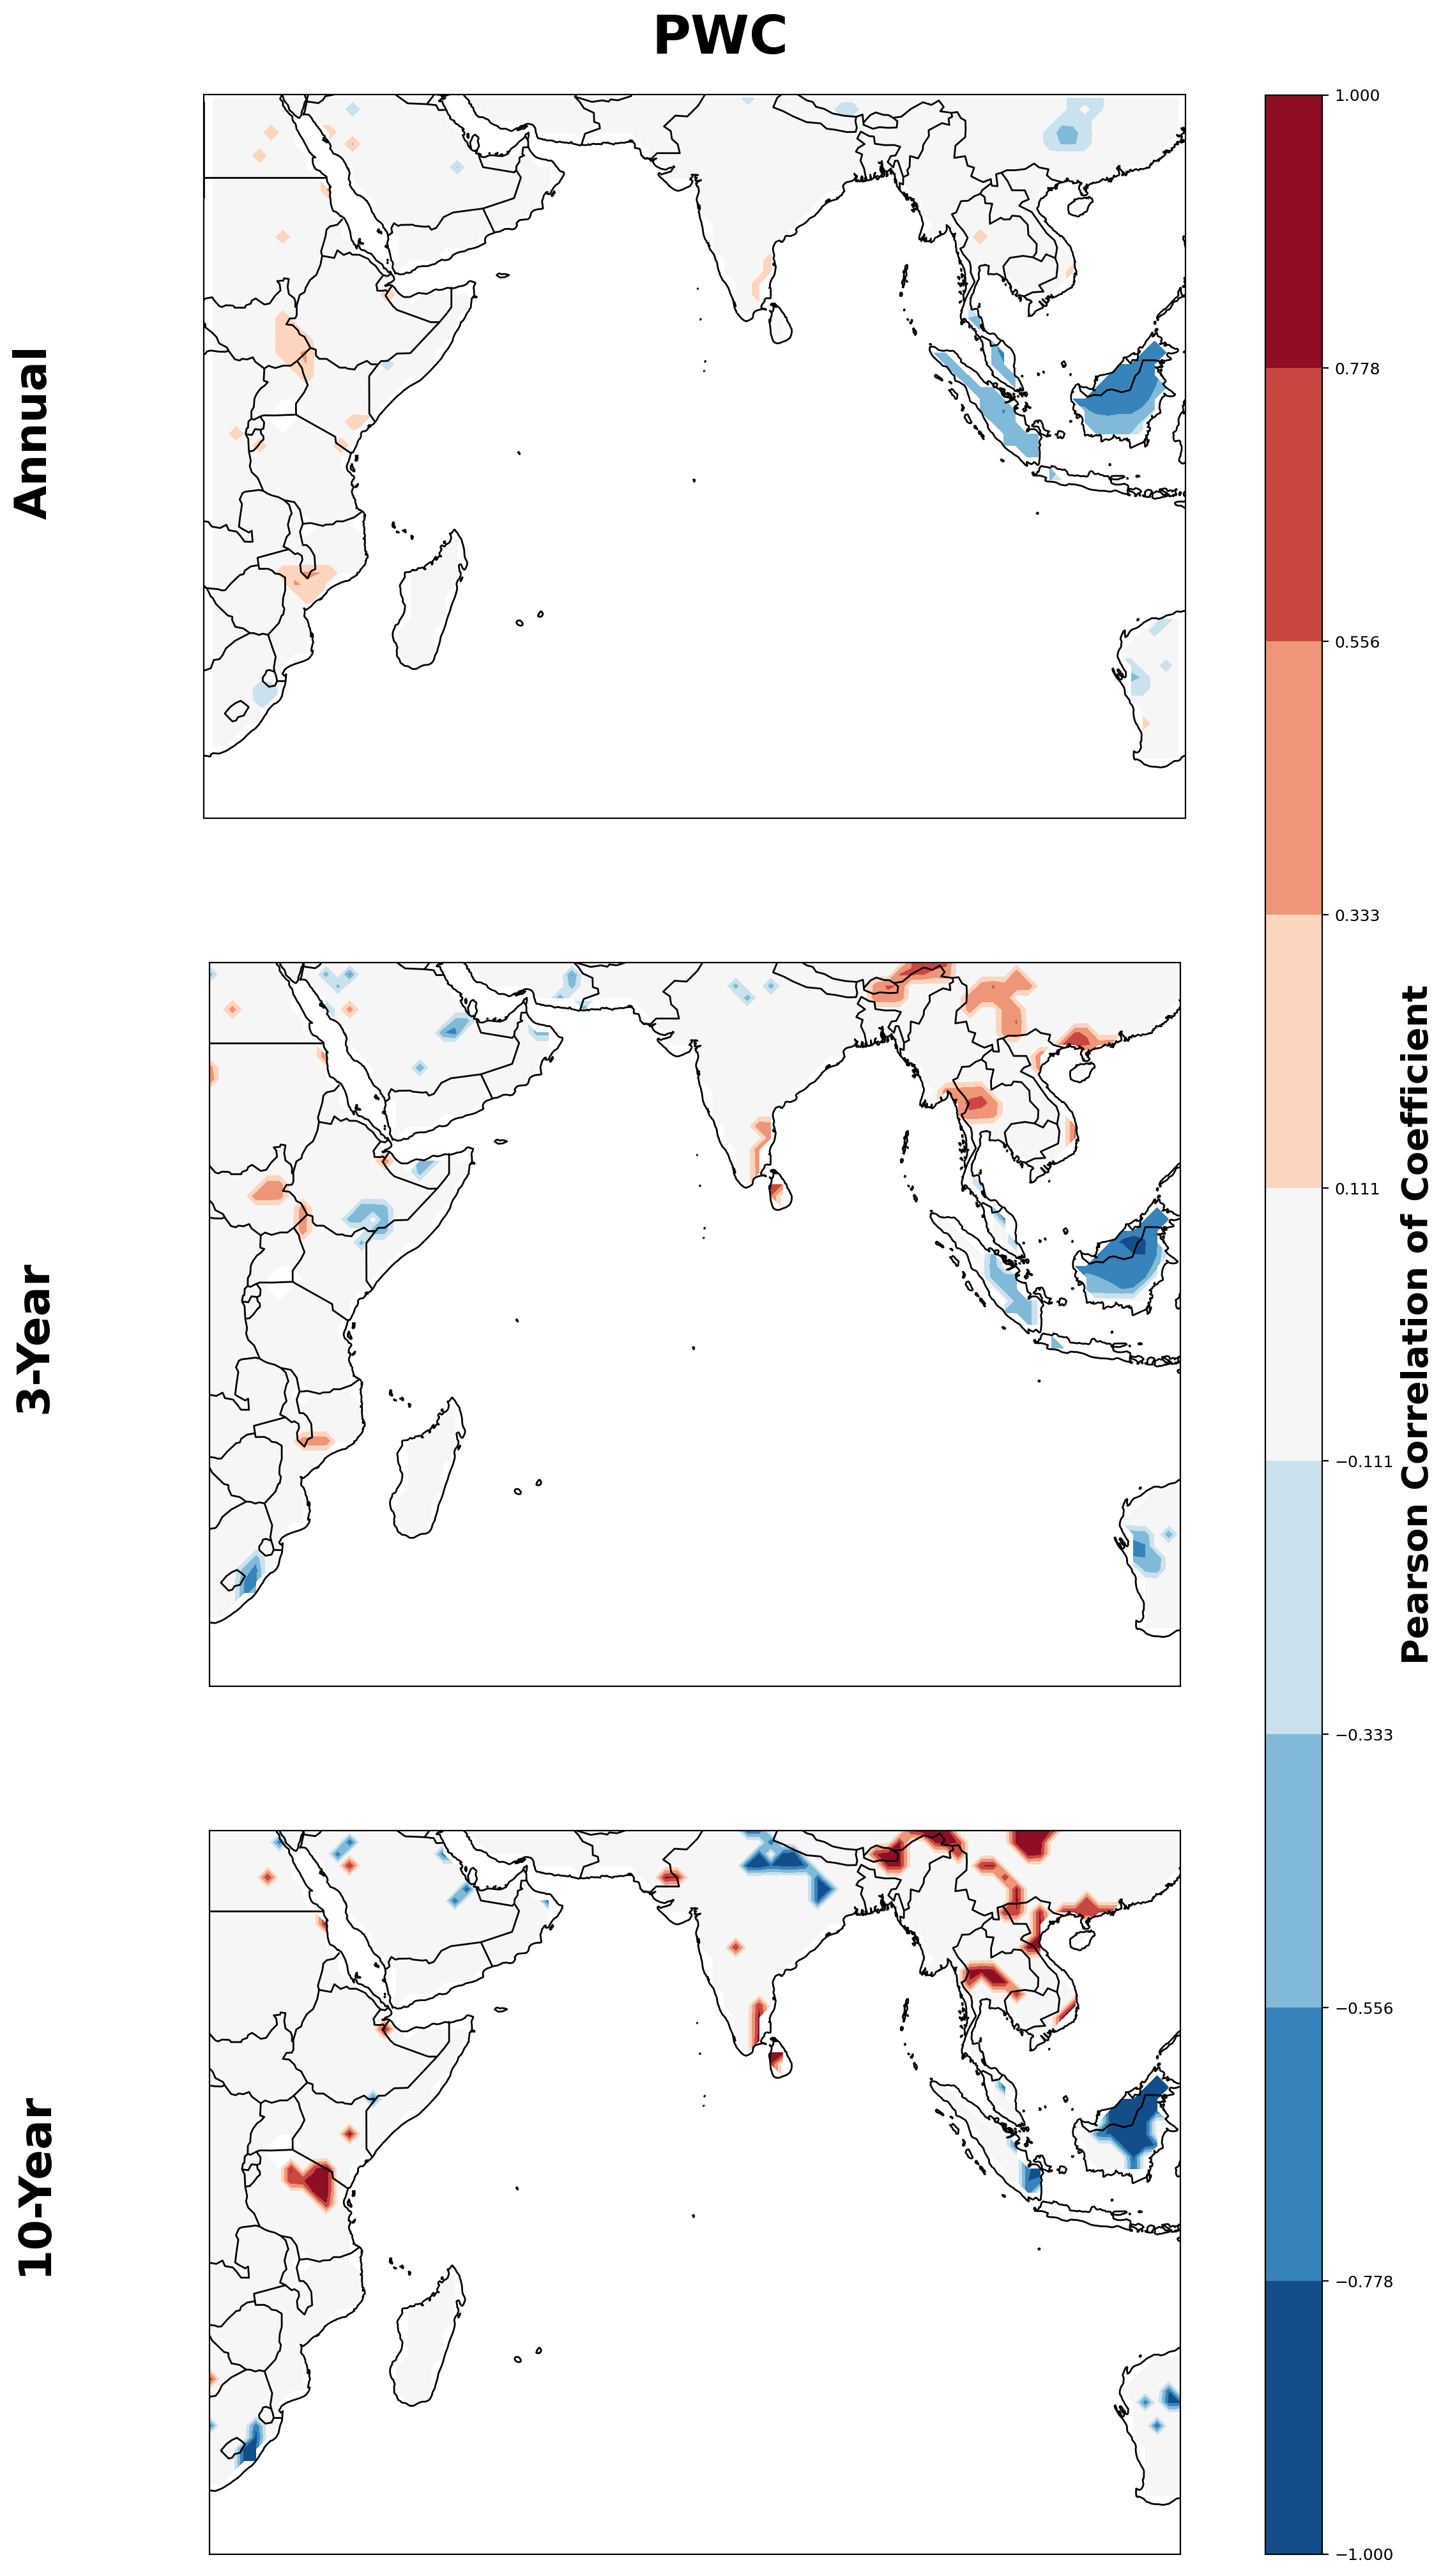

In [63]:
# Spatial Correlation with Colored Contours of d18O_P Amount-Weighted Annual Means and PWC
fig = plt.figure(figsize=(25, 25))
gs = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[1, 1, 1], width_ratios=[1, 0.05], figure=fig)
gs.update(right=0.5, wspace=0, hspace=0.2)

levels = np.linspace(-1, 1, 10)

# PWC; Annual 
ax1 = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=0))
cont1 = ax1.contourf(cor_mapPWC.Longitude, cor_mapPWC.Latitude, cor_mapPWC.values, levels=levels, extedn='both', cmap='RdBu_r')
ax1.set_extent(extent, ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.BORDERS)

# PWC; Amount-Weighted Ann Mean 3-Year
ax2 = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree(central_longitude=0))
cont2 = ax2.contourf(cor_mapPWC3.Longitude, cor_mapPWC3.Latitude, cor_mapPWC3.values, levels=levels, extend='both',cmap='RdBu_r')
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeature.BORDERS)

# PWC; Amount-Weighted Ann Mean 10-Year
ax3 = fig.add_subplot(gs[2,0],projection=ccrs.PlateCarree(central_longitude=0))
cont3 = ax3.contourf(cor_mapPWC10.Longitude, cor_mapPWC10.Latitude, cor_mapPWC10.values, levels=levels, extend='both', cmap='RdBu_r')
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax3.add_feature(cfeature.BORDERS)

fig.text(0.29, 0.893, 'PWC', fontsize = 30, fontweight = 'bold', color = 'k')
fig.text(0.09, 0.75, 'Annual', fontsize = 25, fontweight = 'bold',rotation = 90, color = 'k')
fig.text(0.09, 0.47, '3-Year', fontsize = 25, fontweight = 'bold',rotation = 90, color = 'k')
fig.text(0.09, 0.2, '10-Year', fontsize = 25, fontweight = 'bold',rotation = 90, color = 'k')

# Colorbar
cbar_ax = fig.add_subplot(gs[:, 1])
cbar = plt.colorbar(cont1, cax=cbar_ax, orientation='vertical', extend='both', shrink=0.05)
cbar.ax.tick_params(labelsize=9)
cbar.set_label('Pearson Correlation of Coefficient', fontsize=20, fontweight='bold')

plt.tight_layout()

# Temporal Analysis

## Table S1; October November, December

In [105]:
df = metricsMon.copy()

location = IOB.precip.isel(time=0) * 0 # Land-Sea Mask
ds = echam.where(location != 0) # Selecting only lands
weights = np.cos(np.deg2rad(ds.Latitude))

# Define latitude and longitude slices for different regions
lat_slices = [(0, 15), (-20, 0), (-10, 10)]
lon_slices = [(25, 60), (25, 60), (90, 120)]

region_means = pd.DataFrame(index=df.index)  # Create an empty DataFrame with the correct index

region_names = ['Hrn18O', 'Knya18O', 'Indo18O'] # Three regions: Horn of Africa, Eastern Africa (around Kenya); Indonesia
lat_slices = [(0, 15), (-20, 0), (-10, 10)]
lon_slices = [(25, 60), (25, 60), (90, 120)]

# Loop to calculate regional averages and put outputs into DataFrame
for region_name, (lat_slice, lon_slice) in zip(region_names, zip(lat_slices, lon_slices)):
    region_data = echam.sel(Latitude=slice(*lat_slice), Longitude=slice(*lon_slice)).d18O_P.weighted(weights).mean(dim=('Latitude', 'Longitude')).to_dataframe()
    region_means[region_name] = region_data.values  # Assign values to the corresponding column

# OND Averages for each region
region_means['month']     = region_means.index.month
region_means              = region_means.loc[(region_means.index.month >= 10) & (region_means.index.month <= 12)].resample('Y').mean()
    
# Combine Yearly Metrics and OND Regions
df = df.resample('Y').mean()
dfO = pd.concat([df, region_means], axis=1)
dfO.index = dfO.Year
dfO = dfO.drop(columns=['month'])
#dfO.to_csv(path+'YOUR_FILE_NAME'); Save DF so we can use it for the Coherence Analyses

In [104]:
x = dfO[['u10','dSLPP']]# U10 = IWC; dSLPP = PWC
y = dfO[['Hrn18O','Knya18O','Indo18O']]

In [93]:
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y['Hrn18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.214   
Dependent Variable: Hrn18O           AIC:                131.1593
Date:               2023-12-07 10:33 BIC:                137.2354
No. Observations:   56               Log-Likelihood:     -62.580 
Df Model:           2                F-statistic:        8.498   
Df Residuals:       53               Prob (F-statistic): 0.000629
R-squared:          0.243            Scale:              0.57820 
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -1.9671     0.1042   -18.8692   0.0000   -2.1762   -1.7580
u10       0.6887     0.1734     3.9714   0.0002    0.3409    1.0366
dSLPP    -0.1699     0.1846    -0.9202   0.3616   -0.5402    0.2004
-----------------------------------------------------------------
Omnibus:       

In [94]:
model = sm.OLS(y['Knya18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.274   
Dependent Variable: Knya18O          AIC:                133.8166
Date:               2023-12-07 10:33 BIC:                139.8926
No. Observations:   56               Log-Likelihood:     -63.908 
Df Model:           2                F-statistic:        11.36   
Df Residuals:       53               Prob (F-statistic): 7.82e-05
R-squared:          0.300            Scale:              0.60630 
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -3.9491     0.1068   -36.9936   0.0000   -4.1632   -3.7350
u10       0.7216     0.1776     4.0633   0.0002    0.3654    1.0778
dSLPP     0.0483     0.1891     0.2554   0.7994   -0.3309    0.4275
-----------------------------------------------------------------
Omnibus:       

In [95]:
model = sm.OLS(y['Indo18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.449   
Dependent Variable: Indo18O          AIC:                169.5975
Date:               2023-12-07 10:33 BIC:                175.6736
No. Observations:   56               Log-Likelihood:     -81.799 
Df Model:           2                F-statistic:        23.36   
Df Residuals:       53               Prob (F-statistic): 5.30e-08
R-squared:          0.469            Scale:              1.1486  
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -6.6380     0.1469   -45.1767   0.0000   -6.9327   -6.3432
u10      -1.1653     0.2444    -4.7675   0.0000   -1.6556   -0.6751
dSLPP    -0.5296     0.2602    -2.0349   0.0469   -1.0515   -0.0076
-----------------------------------------------------------------
Omnibus:       

## Table S1; Full Calendar Year (Amount-Weighted Annual Means)

In [106]:
ann     = amount_weighted_ann_mean(IOB,'precip',['d18O_P'])

# Loop to calculate regional averages and put outputs into DataFrame
for region_name, (lat_slice, lon_slice) in zip(region_names, zip(lat_slices, lon_slices)):
    region_data = ann.sel(Latitude=slice(*lat_slice), Longitude=slice(*lon_slice)).d18O_P.weighted(weights).mean(dim=('Latitude', 'Longitude')).to_dataframe()
    region_means[region_name] = region_data.values  # Assign values to the corresponding column
    
# Combine Yearly Metrics and Amount-Weighted Annual Mean Regions
dfA = pd.concat([df, region_means], axis=1)
dfA.index = dfO.Year
dfA = dfA.drop(columns=['month'])
#dfA.to_csv(path+'YOUR_FILE_NAME') we will use this for Coherence Analysis

In [99]:
x = dfA[['u10','dSLPP']]
y = dfA[['Hrn18O','Knya18O','Indo18O']]

x = sm.add_constant(x) # adding a constant

In [100]:
model = sm.OLS(y['Hrn18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.016   
Dependent Variable: Hrn18O           AIC:                100.5162
Date:               2023-12-07 10:46 BIC:                106.5922
No. Observations:   56               Log-Likelihood:     -47.258 
Df Model:           2                F-statistic:        1.435   
Df Residuals:       53               Prob (F-statistic): 0.247   
R-squared:          0.051            Scale:              0.33453 
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -1.9924     0.0793   -25.1265   0.0000   -2.1515   -1.8334
u10       0.1636     0.1319     1.2404   0.2203   -0.1010    0.4282
dSLPP     0.0594     0.1404     0.4231   0.6739   -0.2223    0.3411
-----------------------------------------------------------------
Omnibus:       

In [101]:
model = sm.OLS(y['Knya18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.065  
Dependent Variable: Knya18O          AIC:                44.0282
Date:               2023-12-07 10:46 BIC:                50.1043
No. Observations:   56               Log-Likelihood:     -19.014
Df Model:           2                F-statistic:        2.914  
Df Residuals:       53               Prob (F-statistic): 0.0630 
R-squared:          0.099            Scale:              0.12200
------------------------------------------------------------------
         Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
------------------------------------------------------------------
const   -2.4100     0.0479   -50.3288   0.0000   -2.5061   -2.3140
u10      0.1422     0.0797     1.7847   0.0800   -0.0176    0.3020
dSLPP    0.0491     0.0848     0.5788   0.5652   -0.1210    0.2192
----------------------------------------------------------------
Omnibus:              1.952   

In [103]:
model = sm.OLS(y['Indo18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.484   
Dependent Variable: Indo18O          AIC:                -90.5270
Date:               2023-12-07 10:47 BIC:                -84.4510
No. Observations:   56               Log-Likelihood:     48.264  
Df Model:           2                F-statistic:        26.80   
Df Residuals:       53               Prob (F-statistic): 9.08e-09
R-squared:          0.503            Scale:              0.011037
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -1.4243     0.0144   -98.8889   0.0000   -1.4532   -1.3954
u10      -0.0336     0.0240    -1.4025   0.1666   -0.0817    0.0145
dSLPP    -0.1441     0.0255    -5.6488   0.0000   -0.1953   -0.0929
-----------------------------------------------------------------
Omnibus:       